In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare, RandomEffects, PooledOLS
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy.stats import f as scipyStatsF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

## Bases de dados

In [2]:
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')
df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos_nulos_tratados.csv')

C:\Users\Richa\AppData\Local\Temp\ipykernel_20784\3417393941.py:2: DtypeWarning: Columns (9,42,61,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos_nulos_tratados.csv')


In [3]:
print(df_agrup_munic_ano.columns.tolist())
df_agrup_munic_ano.head()

['Código IBGE', 'ano', 'vlr_investimento', 'pop_beneficiada', 'num_total_empreendimentos', 'aux_emp_metro', 'aux_emp_metro_vlr_investimento', 'aux_emp_pavimentacao', 'aux_emp_pavimentacao_vlr_investimento', 'aux_emp_refrota', 'aux_emp_refrota_vlr_investimento', 'aux_emp_sinalizacao', 'aux_emp_sinalizacao_vlr_investimento', 'aux_emp_calcamento', 'aux_emp_calcamento_vlr_investimento', 'aux_emp_ciclovia', 'aux_emp_ciclovia_vlr_investimento', 'aux_emp_corredor', 'aux_emp_corredor_vlr_investimento', 'aux_emp_drenagem', 'aux_emp_drenagem_vlr_investimento', 'aux_emp_ferrovia', 'aux_emp_ferrovia_vlr_investimento', 'aux_emp_rapido', 'aux_emp_rapido_vlr_investimento', 'aux_emp_vlt', 'aux_emp_vlt_vlr_investimento', 'aux_emp_recapeamento', 'aux_emp_recapeamento_vlr_investimento', 'aux_emp_aero', 'aux_emp_aero_vlr_investimento', 'aux_emp_revitalizacao', 'aux_emp_revitalizacao_vlr_investimento', 'aux_emp_sarjeta', 'aux_emp_sarjeta_vlr_investimento', 'aux_emp_calcadas', 'aux_emp_calcadas_vlr_investim

,Código IBGE,ano,vlr_investimento,pop_beneficiada,num_total_empreendimentos,aux_emp_metro,aux_emp_metro_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,aux_emp_refrota,...,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,Populacao,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,1841.0,2,0,0.0,2,1530000.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,24228.0,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,2087.0,2,0,0.0,0,0.00,0,...,0.177903,0.002156,0.0,0.000000,0.000000,92747.0,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,43512.0,1,0,0.0,1,36842105.26,0,...,0.055415,0.000000,0.0,0.000972,0.000000,102860.0,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,306.0,1,0,0.0,1,265850.00,0,...,0.000000,0.000000,0.0,0.000000,0.000000,6221.0,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,3343.0,3,0,0.0,2,2290724.40,0,...,0.006363,0.000000,0.0,0.000000,0.001273,78574.0,0.0,0.0,0.0,0.0


In [4]:
colunas_obrigatorias = ['total_mortes', 'total_feridos', 'Código IBGE', 'ano']
colunas_programa = list(df_agrup_munic_ano.filter(regex='^programa.*vlr_investimento$').columns) + ['vlr_investimento']

colunas_empreendimentos = df_agrup_munic_ano.filter(like='vlr_investimento').columns.tolist()
colunas_selecionadas = set(colunas_empreendimentos + colunas_obrigatorias) - set(colunas_programa)
df_agrup_munic_ano = df_agrup_munic_ano[colunas_selecionadas]
df_agrup_munic_ano.columns

C:\Users\Richa\AppData\Local\Temp\ipykernel_20784\1908303360.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_agrup_munic_ano = df_agrup_munic_ano[colunas_selecionadas]


Index(['ano', 'aux_emp_ponte_vlr_investimento',
       'aux_emp_sinalizacao_vlr_investimento',
       'aux_emp_transporte_coletivo_vlr_investimento',
       'aux_emp_parque_vlr_investimento', 'aux_emp_refrota_vlr_investimento',
       'aux_emp_corredor_vlr_investimento',
       'aux_emp_recapeamento_vlr_investimento',
       'aux_emp_aero_vlr_investimento', 'aux_emp_ciclovia_vlr_investimento',
       'aux_emp_terminal_vlr_investimento',
       'aux_emp_pavimentacao_vlr_investimento',
       'aux_emp_drenagem_vlr_investimento', 'aux_emp_rapido_vlr_investimento',
       'aux_emp_revitalizacao_vlr_investimento',
       'aux_emp_asfalto_vlr_investimento', 'total_feridos',
       'aux_emp_praca_vlr_investimento', 'aux_emp_vlt_vlr_investimento',
       'aux_emp_calcamento_vlr_investimento',
       'aux_emp_acessibilidade_vlr_investimento',
       'aux_emp_sarjeta_vlr_investimento', 'aux_emp_ferrovia_vlr_investimento',
       'vlr_investimento_per_capita', 'total_mortes', 'Código IBGE',
     

In [5]:
df_agrup_munic_ano.shape

(20700, 29)

## 

## Funções

In [6]:
def matrix_LI(matrix):
    """
    Seleciona colunas linearmente independentes de uma matriz de entrada.

    Esta função remove colunas com todos os valores zero, adiciona uma constante e, em seguida, 
    seleciona colunas linearmente independentes, começando com as duas primeiras colunas da matriz original.

    Parâmetros:
    matrix (pd.DataFrame): O DataFrame de entrada, contendo as colunas e um MultiIndex.

    Retorna:
    pd.DataFrame: Um novo DataFrame contendo apenas colunas linearmente independentes, 
    preservando o MultiIndex original.
    """
    # Removendo colunas com todos os valores zero
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    matrix = sm.add_constant(matrix).astype(float)

    # Selecionar as duas primeiras colunas da matriz original
    initial_columns = matrix.iloc[:, :2]
    remaining_matrix = matrix.iloc[:, 2:].values

    # Inicializa a matriz LI e lista de índices
    LI_matrix = initial_columns.values
    cols_li = initial_columns.columns.tolist()

    for i in range(remaining_matrix.shape[1]):
        # Adiciona uma coluna candidata
        nova_coluna = remaining_matrix[:, i].reshape(-1, 1)
        # Concatena a nova coluna à matriz de colunas LI
        temp_matrix = np.hstack([LI_matrix, nova_coluna])
        # Verifica o posto da nova matriz
        if np.linalg.matrix_rank(temp_matrix) > np.linalg.matrix_rank(LI_matrix):
            LI_matrix = temp_matrix
            cols_li.append(matrix.columns[i + 2])
        # Verificar se já temos o número máximo de colunas LI (igual ao número de linhas)
        if LI_matrix.shape[1] == LI_matrix.shape[0]:
            break

    # Convertendo de volta para DataFrame do Pandas com o MultiIndex original
    new_matrix = pd.DataFrame(LI_matrix, index=matrix.index, columns=cols_li)
    
    return new_matrix

In [7]:
def prepare_panel_data(df, selected_columns=[], check_rank=True):
    """
    Prepara os dados de um DataFrame para análise em painel.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados a serem preparados.
    selected_columns : list, opcional
        Lista de colunas selecionadas para a análise. Se não fornecida, todas as colunas numéricas serão utilizadas.
    check_rank : bool, opcional
        Flag para indicar se a verificação do posto da matriz deve ser realizada.

    Retornos:
    --------
    df_panel : pd.DataFrame
        DataFrame preparado para análise em painel, com as colunas independentes, dependentes e eixos do painel selecionados.
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes com uma constante adicionada.
    y1 : pd.Series
        Série contendo os valores da variável dependente 'total_mortes'.
    y2 : pd.Series
        Série contendo os valores da variável dependente 'total_feridos'.
    """

    # Fixos
    eixos_painel = ['Código IBGE', 'ano']
    y1_name = 'total_mortes'
    y2_name = 'total_feridos'

    if len(selected_columns) == 0:
        selected_columns = df.select_dtypes(include='number').columns.tolist()

    df_panel = df[pd.unique([y1_name, y2_name, *eixos_painel, *selected_columns]).tolist()].copy()
    df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
    df_panel.set_index(['Código IBGE', 'ano'], inplace=True)

    selected_columns = df_panel.columns
    x_columns_selected = selected_columns.drop([y1_name, y2_name]).tolist()

    X = df_panel[x_columns_selected]

    # Resolver problema de posto da matriz
    if check_rank:
        X = matrix_LI(X)
        selected_columns = [y1_name, y2_name, *X.columns.drop('const').tolist()]
        df_panel = df_panel[selected_columns]

    X = sm.add_constant(X).astype(float)
    y1 = df_panel[y1_name].astype(float)
    y2 = df_panel[y2_name].astype(float)

    return df_panel, X, y1, y2

In [8]:
def fit_panel_data_model(X, y, show_summary=True,drop_absorbed=True,cov_error_clusterized=False):
    """
    Ajusta um modelo de dados em painel usando o método de Mínimos Quadrados Ordinários (OLS).

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    show_summary : bool, opcional
        Flag para indicar se o resumo do modelo deve ser exibido. O padrão é True.

    Retornos:
    --------
    model : PanelOLS
        Modelo ajustado de dados em painel.
    """
    # # Cria e ajusta o modelo de dados em painel com efeitos fixos para entidades
    model = PanelOLS(y, X, entity_effects=True,drop_absorbed=drop_absorbed)
    # if cov_error_clusterized:
    #     model = model.fit(cov_type="clustered", cluster_entity=True)
    # else:
    model = model.fit()
    
    # Exibe o resumo do modelo, se solicitado
    if show_summary:
        display(model.summary)
    
    return model



In [9]:
# X

In [10]:
def chow_test(data, break_point, y_var, x_vars):
    """
    Realiza o teste de Chow para verificar a existência de uma quebra estrutural nos dados.

    Parâmetros:
    ----------
    data : pd.DataFrame
        DataFrame contendo os dados em painel com MultiIndex (Código IBGE e ano).
    break_point : int
        Ano que representa o ponto de quebra para o teste de Chow.
    y_var : str
        Nome da variável dependente no DataFrame.
    x_vars : list of str
        Lista dos nomes das variáveis independentes no DataFrame.

    Retorno:
    -------
    dict
        Dicionário contendo o valor do estatístico F e o p-valor do teste de Chow.
    """
    # Dividindo os dados em dois subconjuntos com base no ponto de quebra
    df_pre_break = data.loc[data.index.get_level_values('ano') < break_point]
    df_post_break = data.loc[data.index.get_level_values('ano') >= break_point]

    # Extraindo as variáveis dependente e independente para os dois subconjuntos
    y_pre, X_pre = df_pre_break[y_var], df_pre_break[x_vars]
    y_post, X_post = df_post_break[y_var], df_post_break[x_vars]

    # Adicionando uma constante (intercepto) aos modelos
    X_pre = sm.add_constant(X_pre)
    X_post = sm.add_constant(X_post)
    
    # Ajustando os modelos de regressão para os dois subconjuntos
    # model_pre = sm.OLS(y_pre, X_pre).fit()
    # model_post = sm.OLS(y_post, X_post).fit()
    model_pre = PooledOLS(y_pre, X_pre,check_rank=False).fit()
    model_post = PooledOLS(y_post, X_post,check_rank=False).fit()
    
    # Ajustando o modelo de regressão para o conjunto completo de dados
    y, X = data[y_var], data[x_vars]
    X = sm.add_constant(X)
    # model_full = sm.OLS(y, X).fit()
    model_full = PooledOLS(y, X,check_rank=False).fit()

    # Calculando os resíduos quadrados dos modelos
    # RSS_pre = model_pre.ssr
    # RSS_post = model_post.ssr
    # RSS_full = model_full.ssr
    RSS_pre = sum(model_pre.resids ** 2)
    RSS_post = sum(model_post.resids ** 2)
    RSS_full = sum(model_full.resids ** 2)

    # Calculando o número de parâmetros
    k = X_pre.shape[1]
    N_pre, N_post = X_pre.shape[0], X_post.shape[0]

    # Calculando o estatístico F do teste de Chow
    chow_stat = ((RSS_full - (RSS_pre + RSS_post)) / k) / ((RSS_pre + RSS_post) / (N_pre + N_post - 2 * k))
    df1 = k
    df2 = N_pre + N_post - 2 * k
    p_value = scipyStatsF.sf(chow_stat, df1, df2)

    return {"F-statistic": chow_stat, "p-value": p_value}

In [11]:


def run_chow_tests(data, y_var, x_vars):
    """
    Executa o teste de Chow para cada ano no intervalo de anos presente nos dados.

    Parâmetros:
    ----------
    data : pd.DataFrame
        DataFrame contendo os dados em painel com MultiIndex (Código IBGE e ano).
    y_var : str
        Nome da variável dependente no DataFrame.
    x_vars : list of str
        Lista dos nomes das variáveis independentes no DataFrame.

    Retorno:
    -------
    pd.DataFrame
        DataFrame contendo os resultados do teste de Chow para cada ano.
    """
    # Obtendo o ano inicial e final do índice 'ano'
    start_year = data.index.get_level_values('ano').min()
    end_year = data.index.get_level_values('ano').max()
    
    # Lista para armazenar os resultados do teste de Chow
    results = []
    
    # Iterando sobre os anos no intervalo especificado
    for year in range(int(start_year)+1, int(end_year)):
        # Executando o teste de Chow para o ano atual
        result = chow_test(data, year, y_var, x_vars)
        result['Year'] = year
        results.append(result)
    
    # Retornando um DataFrame com os resultados do teste de Chow para cada ano
    return pd.DataFrame(results)


In [12]:


def teste_BP(data, y_var, x_vars):
    """
    Executa o teste de Breusch-Pagan para heteroscedasticidade nos resíduos de um modelo OLS.

    Args:
        data (pd.DataFrame): DataFrame contendo os dados.
        y_var (str): Nome da variável dependente no DataFrame.
        x_vars (list of str): Lista dos nomes das variáveis independentes no DataFrame.

    Returns:
        None: Imprime os resultados do teste de Breusch-Pagan, incluindo as estatísticas LM e F e seus valores p correspondentes.
    """
    # Extraindo as variáveis dependente e independente
    y = data[y_var]
    X = data[x_vars]

    # Adicionando uma constante (intercepto) ao modelo
    X = sm.add_constant(X)

    # Ajustando o modelo de regressão OLS
    # model_ols = sm.OLS(y, X).fit()
    model_ols = PooledOLS(y, X).fit()

    # Realizando o teste de Breusch-Pagan para verificar a heteroscedasticidade dos resíduos
    LM, LM_pv, F, F_pv = het_breuschpagan(model_ols.resids.values, model_ols.model.exog.dataframe)

    # Definindo rótulos para os valores retornados pelo teste
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

    # Exibindo os resultados do teste de Breusch-Pagan
    print(f"\n\nBreusch-Pagan Test for Total {y_var}:")
    print(dict(zip(labels, (LM, LM_pv, F, F_pv))))

    # Interpretando os resultados do teste de homoscedasticidade
    # A hipótese nula do teste é de homoscedasticidade (variância constante dos resíduos).
    # Se ambos os valores p (LM_pv e F_pv) forem maiores que 0,05, não rejeitamos a hipótese nula.
    # Caso contrário, rejeitamos a hipótese nula, indicando heteroscedasticidade no modelo Pooled.
    print(f"\nHipótese de Homoscedasticidade do modelo Pooled {'Não' if ((LM_pv > .05) and (F_pv > .05)) else ''} Rejeitada")




In [13]:
# model_ols.ssr#.model.exog.dataframe

In [14]:
def plot_residuos(model, y_name):
    """
    Plota a distribuição dos resíduos e a relação entre resíduos e valores ajustados para um modelo de regressão.

    Parâmetros:
    ----------
    model : PanelOLS
        Modelo de dados em painel ajustado.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos gráficos.

    """
    # Plota a distribuição dos resíduos
    plt.hist(model.resids, bins=50, edgecolor='k')
    plt.title(f'Distribuição dos Resíduos - {y_name}')
    plt.xlabel('Resíduos')
    plt.ylabel('Frequência')
    plt.show()

    # Plota os resíduos versus os valores ajustados
    plt.scatter(model.fitted_values, model.resids, alpha=0.5)
    plt.title(f'Resíduos vs Valores Ajustados - {y_name}')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos')
    plt.show()


In [15]:
def effect_by_year(df, model, show_resid_graph=True):
    """
    Avalia o efeito dos resíduos do modelo ao longo dos anos e realiza o teste de Breusch-Pagan para cada ano.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.
    show_resid_graph : bool, opcional
        Flag para indicar se o gráfico dos resíduos médios ao longo do tempo deve ser exibido. O padrão é True.

    """
    df_aux = df.copy()
    
    # Adiciona os resíduos do modelo ao DataFrame auxiliar
    df_aux = df_aux.merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)

    if show_resid_graph:
        # Calcula os resíduos médios por ano e por município
        residuos_por_ano = df_aux.groupby('ano')['residuos'].mean()
        residuos_por_municipio = df_aux.groupby('Código IBGE')['residuos'].mean()

        # Plota os resíduos médios ao longo do tempo
        plt.figure(figsize=(10, 6))
        plt.plot(residuos_por_ano, 'o-')
        plt.title('Resíduos Médios ao Longo do Tempo')
        plt.xlabel('Ano')
        plt.ylabel('Resíduos Médios')
        plt.show()

    # Realiza o teste de Breusch-Pagan para cada ano
    bp_results_ano = {}
    for year in df_aux['ano'].unique():
        df_year = df_aux[df_aux['ano'] == year]
        exog_year = df_year[df_year.columns.drop(['total_feridos', 'total_mortes'])]
        exog_year = sm.add_constant(exog_year)  # Adiciona uma constante
        _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_year['residuos'], exog_year)
        bp_results_ano[year] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe
    bp_results_ano_df = pd.DataFrame(bp_results_ano).T
    display(bp_results_ano_df)


In [16]:
def effect_by_city(df, model):
    """
    Avalia o efeito dos resíduos do modelo por município e realiza o teste de Breusch-Pagan para cada município.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados originais.
    model : PanelOLS
        Modelo de dados em painel ajustado.

    """
    # Cria um DataFrame auxiliar e adiciona os resíduos do modelo
    df_aux = df.copy().merge(model.resids, how='left', on=['Código IBGE', 'ano']).reset_index()
    df_aux.rename(columns={'residual': 'residuos'}, inplace=True)
    
    # Realiza o teste de Breusch-Pagan para cada município
    bp_results_municipio = {}
    for municipio in df_aux['Código IBGE'].unique():
        df_municipio = df_aux[df_aux['Código IBGE'] == municipio]
        if len(df_municipio) > 1:  # Certifica-se de que há mais de uma observação por município
            exog_municipio = df_municipio[df_municipio.columns.drop(['total_feridos', 'total_mortes'])]
            exog_municipio = sm.add_constant(exog_municipio)  # Adiciona uma constante
            _, lm_pvalue, _, f_pvalue = het_breuschpagan(df_municipio['residuos'], exog_municipio)
            bp_results_municipio[municipio] = {'LM p-value': lm_pvalue, 'F p-value': f_pvalue}

    # Converte os resultados do teste de Breusch-Pagan para um DataFrame e exibe a descrição estatística
    bp_results_municipio_df = pd.DataFrame(bp_results_municipio).T
    print(bp_results_municipio_df.describe())




In [17]:
# Calcular o VIF para cada variável independente
def VIF(X):
    X_vif = sm.add_constant(X)  # Adicionar constante
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    return vif_data

In [18]:
import scipy.stats as stats
def compare_random_fixed_panel(X, y):
    """
    Compara os modelos de efeitos fixos e aleatórios para um conjunto de dados em painel.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.

    """
    # Ajusta o modelo de efeitos fixos
    fe_model = PanelOLS(y, X, entity_effects=True,drop_absorbed=True).fit()
    
    # Ajusta o modelo de efeitos aleatórios
    re_model = RandomEffects(y, X).fit()
    
    # Compara os dois modelos
    comparison = compare({'Fixed Effects': fe_model, 'Random Effects': re_model})
    
    # Exibe a comparação dos modelos
    display(comparison)

    # Cálculo do teste de Hausman
    b = fe_model.params
    B = re_model.params
    v_b = fe_model.cov
    v_B = re_model.cov
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    p_value = stats.chi2(b.size-1).sf(chi2)


    # # Hausman test for fixed versus random effects model
    # # null hypothesis: random effects model
    # psi = fixed.cov - random.cov.iloc[1:,1:]
    # diff = fixed.params - random.params[1:]
    # # psi = fixed1.cov.iloc[1:,1:] - random.cov.iloc[1:,1:]
    # # diff = fixed1.params[1:] - random.params[1:]
    # W = diff.dot(np.linalg.inv(psi)).dot(diff)
    # dof = random.params.size -1
    # pvalue = stats.chi2(dof).sf(W)
    # print("Hausman Test: chisq = {0}, df = {1}, p-value = {2}".format(W, dof, pvalue))
    
    print(f"Teste de Hausman\nEstatística chi2: {chi2}\nP-valor: {p_value}")
    print(f"Hipótese Nula: {'Não' if p_value < 0.05 else ''} Rejeitada (Efeitos aleatórios são preferidos)")


In [19]:
def fit_random_effect(X, y, show_summary=True):
    # Modelo de Efeitos Aleatórios para Mortes
    fitted_model = RandomEffects(y, X).fit()
    if show_summary:
        display(fitted_model.summary)
    return fitted_model

In [20]:
def salva_coeficientes(model):
    """
    Salva os coeficientes de um modelo estatístico em um arquivo CSV.

    Parâmetros:
    model (Statsmodels object): O modelo estatístico.

    Retorna:
    None
    """
    variavel_dependente = pd.DataFrame(model.summary.tables[0][0]).iloc[1]

    variavel_dependente = str(variavel_dependente.values[0])

    summary_df = pd.DataFrame(model.summary.tables[1])

    summary_df.columns = summary_df.iloc[0]
    summary_df = summary_df[1:]

    summary_df.rename(columns={summary_df.columns[0]: variavel_dependente}, inplace=True)

    if not os.path.exists('resultados_modelo'):
            os.makedirs('resultados_modelo')

    summary_df.to_csv(f'resultados_modelo/geral_{variavel_dependente}.csv', index=False)

In [21]:
def get_top_municip(df_empreend, pop=100000):
    """
    Filtra os municípios com população maior que um valor especificado e retorna os principais municípios
    ordenados pela população.

    Parâmetros:
    -----------
    df_empreend : pandas.DataFrame
        DataFrame contendo os dados dos municípios, incluindo a população e o código IBGE.
    
    pop : int, opcional
        O limite mínimo de população para considerar um município como "principal". O valor padrão é 100000.

    Retornos:
    ---------
    df_top_munic : pandas.DataFrame
        DataFrame contendo os municípios com população acima do limite especificado, ordenados pela população
        em ordem decrescente. Inclui as colunas 'Código IBGE', 'Município' e 'Populacao'.
    
    id_cidades_principais : numpy.ndarray
        Array contendo os códigos IBGE dos municípios selecionados.
    """
    # Filtra o DataFrame para incluir apenas os municípios com população maior que 'pop'
    df_top_munic = df_empreend[df_empreend.Populacao > pop][['Código IBGE', 'Município', 'Populacao']]
    
    # Agrupa os dados pelos códigos IBGE e nome dos municípios, e seleciona a maior população registrada para cada grupo
    df_top_munic = df_top_munic.groupby(['Código IBGE', 'Município']).max()['Populacao']
    
    # Ordena os municípios pela população em ordem decrescente
    df_top_munic = df_top_munic.sort_values(ascending=False).reset_index()
    
    # Extrai os códigos IBGE dos municípios selecionados para um array
    id_cidades_principais = df_top_munic['Código IBGE'].values
    
    # Retorna o DataFrame dos principais municípios e o array dos códigos IBGE
    return df_top_munic, id_cidades_principais


In [22]:
def get_capitais(df_empreend):
    """
    Filtra os municípios que são capitais de estado e retorna esses municípios.

    Parâmetros:
    -----------
    df_empreend : pandas.DataFrame
        DataFrame contendo os dados dos municípios, incluindo uma coluna que indica se o município é uma capital.
    
    Retornos:
    ---------
    df_capitais : pandas.DataFrame
        DataFrame contendo os municípios que são capitais de estado. Inclui as colunas 'Código IBGE' e 'Município'.
    
    id_cidades_principais : numpy.ndarray
        Array contendo os códigos IBGE dos municípios que são capitais de estado.
    """
    # Filtra o DataFrame para incluir apenas os municípios que são capitais
    df_capitais = df_empreend[df_empreend['mun_CAPITAL'].astype(str) == 'S'][['Código IBGE', 'Município']]
    
    # Remove duplicatas e valores ausentes
    df_capitais = df_capitais.drop_duplicates().dropna().reset_index(drop=True)
    
    # Extrai os códigos IBGE dos municípios selecionados para um array
    id_cidades_principais = df_capitais['Código IBGE'].values
    
    # Retorna o DataFrame dos municípios capitais e o array dos códigos IBGE
    return df_capitais, id_cidades_principais


## Seleciona variáveis para os dados em painel

**Eixos:**

eixo transversal = $Município$

eixo temporal = $ano$

**Variáveis dependentes:**

$y_1=total\_mortes$

$y_2=total\_feridos$

**Variáveis independentes:**

$X =$ variáveis numéricas excluindo colunas que tornam a matriz LD

Variáveis explicativas escolhidas, a princípio,  de forma arbitrária:

In [23]:
df_panel, X, y_mortes, y_feridos = prepare_panel_data(df_agrup_munic_ano.copy())
X

const  aux_emp_ponte_vlr_investimento  \
Código IBGE ano                                             
1100015.0   2011.0    1.0                             0.0   
1100023.0   2012.0    1.0                             0.0   
            2014.0    1.0                             0.0   
1100031.0   2011.0    1.0                             0.0   
1100049.0   2010.0    1.0                             0.0   
...                   ...                             ...   
5300108.0   2015.0    1.0                             0.0   
            2016.0    1.0                             0.0   
            2017.0    1.0                             0.0   
            2018.0    1.0                             0.0   
            2019.0    1.0                             0.0   

                    aux_emp_sinalizacao_vlr_investimento  \
Código IBGE ano                                            
1100015.0   2011.0                                   0.0   
1100023.0   2012.0                                   0.0   
            2014.0                                   0.0   
1100031.0   2011.0                                   0.0   
1100049.0   2010.0                                   0.0   
...                                                  ...   
5300108.0   2015.0                                   0.0   
            2016.0                                   0.0   
            2017.0                                   0.0   
            2018.0                                   0.0   
            2019.0                                   0.0   

                    aux_emp_transporte_coletivo_vlr_investimento  \
Código IBGE ano                                                    
1100015.0   2011.0                                           0.0   
1100023.0   2012.0                                           0.0   
            2014.0                                           0.0   
1100031.0   2011.0                                           0.0   
1100049.0   2010.0                                           0.0   
...                                                          ...   
5300108.0   2015.0                                           0.0   
            2016.0                                           0.0   
            2017.0                                           0.0   
            2018.0                                           0.0   
            2019.0                                           0.0   

                    aux_emp_parque_vlr_investimento  \
Código IBGE ano                                       
1100015.0   2011.0                             0.00   
1100023.0   2012.0                             0.00   
            2014.0                             0.00   
1100031.0   2011.0                             0.00   
1100049.0   2010.0                             0.00   
...                                             ...   
5300108.0   2015.0                       2745666.67   
            2016.0                             0.00   
            2017.0                       1523183.18   
            2018.0                             0.00   
            2019.0                             0.00   

                    aux_emp_refrota_vlr_investimento  \
Código IBGE ano                                        
1100015.0   2011.0                               0.0   
1100023.0   2012.0                               0.0   
            2014.0                               0.0   
1100031.0   2011.0                               0.0   
1100049.0   2010.0                               0.0   
...                                              ...   
5300108.0   2015.0                               0.0   
            2016.0                               0.0   
            2017.0                               0.0   
            2018.0                               0.0   
            2019.0                               0.0   

                    aux_emp_corredor_vlr_investimento  \
Código IBGE ano                                         
1

In [24]:
X.shape

(20700, 26)

In [25]:
set(df_agrup_munic_ano.columns) - set(X.columns)

{'Código IBGE', 'ano', 'total_feridos', 'total_mortes'}

#### Teste de Chow para quebra estrutural no modelo Pooled

In [26]:
results_df = run_chow_tests(df_panel, 'total_mortes', X.columns.drop('const').tolist())
results_df

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

,F-statistic,p-value,Year
0,45.415885,8.897169e-226,2011
1,49.131938,3.419269e-245,2012
2,44.842482,8.911834e-223,2013
3,26.214069,8.892235e-125,2014
4,34.731722,1.109389e-169,2015
5,17.184666,2.737767e-77,2016
6,11.959540,3.642775e-50,2017
7,8.982265,4.911644e-35,2018


In [27]:
results_df = run_chow_tests(df_panel, 'total_feridos', X.columns.drop('const').tolist())
print(results_df)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

   F-statistic        p-value  Year
0    35.403073  3.238730e-173  2011
1    36.049469  1.282543e-176  2012
2    24.109075  1.114282e-113  2013
3    31.753416  5.459626e-154  2014
4    52.074475  1.586834e-260  2015
5    40.491775  5.716769e-200  2016
6    34.290024  2.350754e-167  2017
7    26.453302  4.868329e-126  2018


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

#### Teste de Breusch-Pagan para heteroscedasticidade

$H_0: Homoscedástico$

In [28]:
x_vars = X.drop('const', axis=1).columns.tolist()

teste_BP(df_panel, 'total_mortes', x_vars)
teste_BP(df_panel, 'total_feridos', x_vars)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=



Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 377.3219184676778, 'LM-Test p-value': 1.3392539666693512e-64, 'F-Statistic': 15.353790107986768, 'F-Test p-value': 2.9582533301076207e-65}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 394.9577818410758, 'LM-Test p-value': 3.343379860194819e-68, 'F-Statistic': 16.085378388388808, 'F-Test p-value': 6.3163156288372e-69}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(

## Efeitos Fixos

**Modelo simplificado**

$$y_{it} = \gamma_t + \beta'x_{it} + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [29]:
model_mortes = fit_panel_data_model(X, y_mortes,cov_error_clusterized=False)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.3689
Estimator:,PanelOLS,R-squared (Between):,0.0724
No. Observations:,20700,R-squared (Within):,0.3689
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.1237
Time:,11:59:42,Log-likelihood,-7.898e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,360.75
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,15431)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,360.75


In [30]:
model_feridos = fit_panel_data_model(X, y_feridos,cov_error_clusterized=False)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.0642
Estimator:,PanelOLS,R-squared (Between):,0.0197
No. Observations:,20700,R-squared (Within):,0.0642
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0306
Time:,11:59:43,Log-likelihood,-1.215e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,42.349
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,15431)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,42.349


In [31]:
# salva_coeficientes(model_mortes)

In [32]:
# salva_coeficientes(model_feridos)

### Resíduos

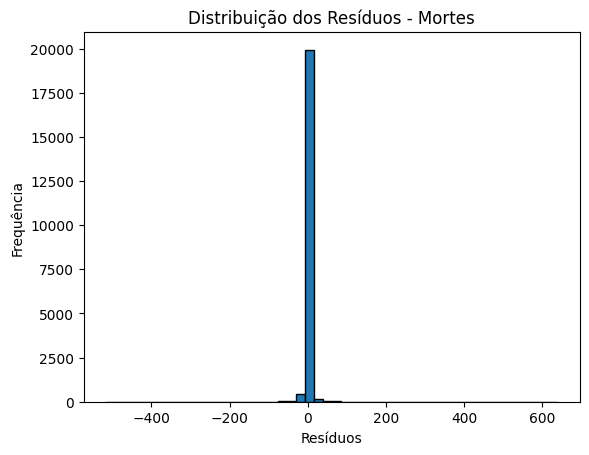

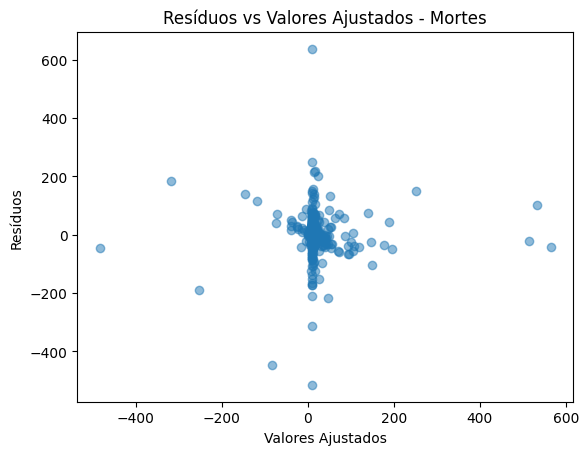

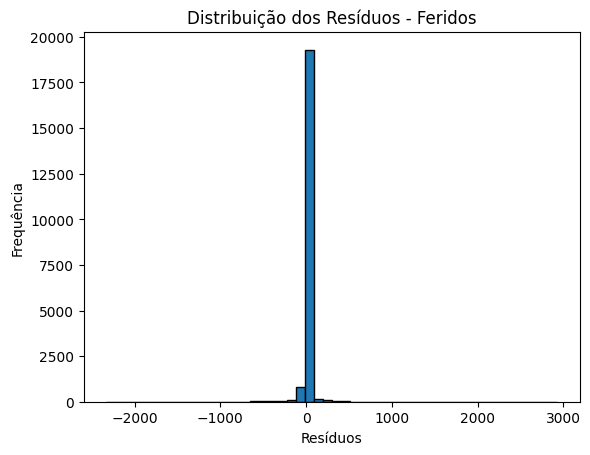

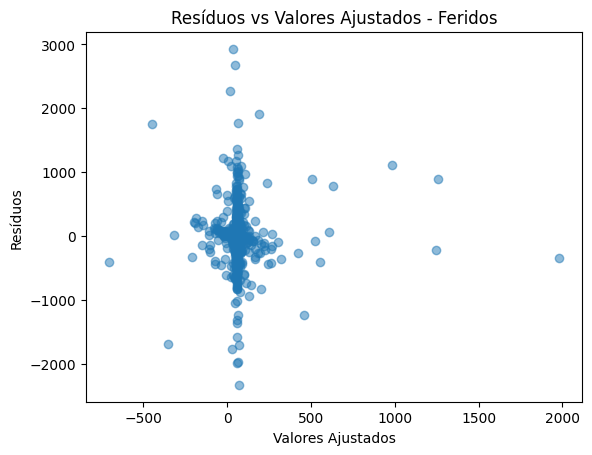

In [33]:
plot_residuos(model_mortes, 'Mortes')

plot_residuos(model_feridos, 'Feridos')

In [34]:
# teste_BP(model_mortes, 'Mortes')
# teste_BP(model_feridos, 'Feridos')

### Resíduos por efeito de munícipio ou ano 

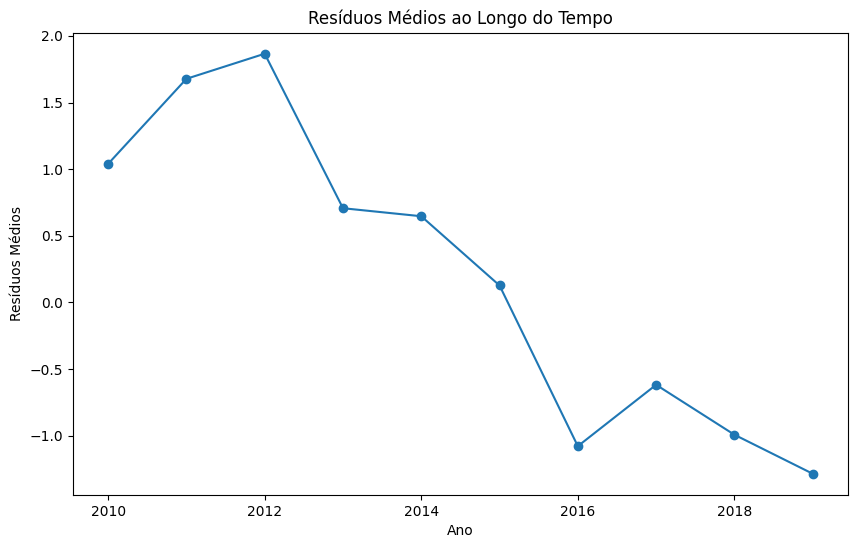

,LM p-value,F p-value
2011.0,1.682670e-238,0.000000e+00
2012.0,1.200116e-168,4.411266e-315
2014.0,9.535775e-233,0.000000e+00
2010.0,0.000000e+00,0.000000e+00
2013.0,0.000000e+00,0.000000e+00
2019.0,2.275367e-285,0.000000e+00
2015.0,1.000623e-243,0.000000e+00
2016.0,0.000000e+00,0.000000e+00
2017.0,4.181938e-287,0.000000e+00
2018.0,0.000000e+00,0.000000e+00


In [35]:
effect_by_year(df_panel, model_mortes)

In [36]:
# effect_by_city(df_panel, model_mortes)

### Regressão Quantilica

In [37]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

# Modelo de Regressão Quantílica para Mortes
quantile_model_mortes = QuantReg(y_mortes, X).fit(q=0.5)
quantile_model_mortes.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:           total_mortes   Pseudo R-squared:              0.07865
Model:                       QuantReg   Bandwidth:                      0.7466
Method:                 Least Squares   Sparsity:                        5.330
Date:                Sat, 08 Jun 2024   No. Observations:                20700
Time:                        11:59:47   Df Residuals:                    20674
                                        Df Model:                           25
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                         6.994e-12   9.94e-07   7.04e-06      1.000   -1.95e-06    1.95e-06
aux_emp_ponte_vlr_investimento                8.432e-07   8.75e-09     96.315      0.000    8.26e-07     8.6e-07
aux_emp_sinalizacao_vlr_investimento          8.571e-07   1.54e-08     55.670      0.000    8.27e-07    8.87e-07
aux_emp_transporte_coletivo_vlr_investimento  3.962e-07   1.43e-09    277.066      0.000    3.93e-07    3.99e-07
aux_emp_parque_vlr_investimento               3.257e-06   9.42e-08     34.579      0.000    3.07e-06    3.44e-06
aux_emp_refrota_vlr_investimento              2.805e-06   1.98e-08    141.705      0.000    2.77e-06    2.84e-06
aux_emp_corredor_vlr_investimento             6.806e-08   1.29e-09     52.687      0.000    6.55e-08    7.06e-08
aux_emp_recapeamento_vlr_investimento         2.017e-06   1.16e-08    173.887      0.000    1.99e-06    2.04e-06
aux_emp_aero_vlr_investimento                 3.221e-07   1.29e-09    249.480      0.000     3.2e-07    3.25e-07
aux_emp_ciclovia_vlr_investimento            -1.489e-06   1.13e-08   -131.905      0.000   -1.51e-06   -1.47e-06
aux_emp_terminal_vlr_investimento             1.574e-06   4.81e-09    327.471      0.000    1.56e-06    1.58e-06
aux_emp_pavimentacao_vlr_investimento         1.864e-06   3.24e-09    574.669      0.000    1.86e-06    1.87e-06
aux_emp_drenagem_vlr_investimento            -5.034e-07   6.15e-09    -81.874      0.000   -5.15e-07   -4.91e-07
aux_emp_rapido_vlr_investimento               2.082e-07   1.38e-09    150.379      0.000    2.06e-07    2.11e-07
aux_emp_revitalizacao_vlr_investimento        2.478e-06   2.82e-08     87.883      0.000    2.42e-06    2.53e-06
aux_emp_asfalto_vlr_investimento              9.797e-07   2.12e-08     46.252      0.000    9.38e-07    1.02e-06
aux_emp_praca_vlr_investimento                6.512e-07   2.05e-08     31.774      0.000    6.11e-07    6.91e-07
aux_emp_vlt_vlr_investimento                  3.207e-08    1.5e-09     21.357      0.000    2.91e-08     3.5e-08
aux_emp_calcamento_vlr_investimento           2.408e-06   8.59e-08     28.029      0.000    2.24e-06    2.58e-06
aux_emp_acessibilidade_vlr_investimento      -3.903e-07   2.12e-08    -18.405      0.000   -4.32e-07   -3.49e-07
aux_emp_sarjeta_vlr_investimento              2.457e-06   5.09e-08     48.290      0.000    2.36e-06    2.56e-06
aux_emp_ferrovia_vlr_investimento             2.938e-07   5.69e-10    516.150      0.000    2.93e-07    2.95e-07
vlr_investimento_per_capita                  -8.032e-10      0.000  -4.35e-06      1.000      -0.000       0.000
aux_emp_calcadas_vlr_investimento             3.115e-07   2.89e-09    107.948      0.000    3.06e-07    3.17e-07
aux_emp_passeio_vlr_investimento              1.646e-09   1.54e-08      0.107      0.915   -2.86e-08    3.19e-08
aux_emp_metro_vlr_investimento               -5.904e-08    2.8e-10   -210.670      0.000   -5.96e-08   -5.85e-08
===========================================

In [38]:
# Modelo de Regressão Quantílica para Feridos
quantile_model_feridos = QuantReg(y_feridos, X).fit(q=0.5)
quantile_model_feridos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:          total_feridos   Pseudo R-squared:              0.07653
Model:                       QuantReg   Bandwidth:                     0.02475
Method:                 Least Squares   Sparsity:                       0.2688
Date:                Sat, 08 Jun 2024   No. Observations:                20700
Time:                        11:59:48   Df Residuals:                    20674
                                        Df Model:                           25
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                        -8.182e-11   5.01e-08     -0.002      0.999   -9.83e-08    9.81e-08
aux_emp_ponte_vlr_investimento                1.956e-05   4.41e-10   4.43e+04      0.000    1.96e-05    1.96e-05
aux_emp_sinalizacao_vlr_investimento          6.329e-09   7.76e-10      8.154      0.000    4.81e-09    7.85e-09
aux_emp_transporte_coletivo_vlr_investimento  1.351e-06   7.21e-11   1.87e+04      0.000    1.35e-06    1.35e-06
aux_emp_parque_vlr_investimento               1.608e-06   4.75e-09    338.627      0.000     1.6e-06    1.62e-06
aux_emp_refrota_vlr_investimento              6.675e-05   9.98e-10   6.69e+04      0.000    6.67e-05    6.68e-05
aux_emp_corredor_vlr_investimento             9.122e-07   6.51e-11    1.4e+04      0.000    9.12e-07    9.12e-07
aux_emp_recapeamento_vlr_investimento         2.587e-06   5.85e-10   4423.796      0.000    2.59e-06    2.59e-06
aux_emp_aero_vlr_investimento                 2.693e-06   6.51e-11   4.14e+04      0.000    2.69e-06    2.69e-06
aux_emp_ciclovia_vlr_investimento            -2.103e-07   5.69e-10   -369.686      0.000   -2.11e-07   -2.09e-07
aux_emp_terminal_vlr_investimento             7.275e-06   2.42e-10      3e+04      0.000    7.27e-06    7.28e-06
aux_emp_pavimentacao_vlr_investimento         1.329e-07   1.64e-10    812.325      0.000    1.33e-07    1.33e-07
aux_emp_drenagem_vlr_investimento             5.863e-08    3.1e-10    189.136      0.000     5.8e-08    5.92e-08
aux_emp_rapido_vlr_investimento               2.771e-06   6.98e-11   3.97e+04      0.000    2.77e-06    2.77e-06
aux_emp_revitalizacao_vlr_investimento        1.644e-05   1.42e-09   1.16e+04      0.000    1.64e-05    1.64e-05
aux_emp_asfalto_vlr_investimento              2.923e-07   1.07e-09    273.678      0.000     2.9e-07    2.94e-07
aux_emp_praca_vlr_investimento                7.396e-06   1.03e-09   7157.253      0.000    7.39e-06     7.4e-06
aux_emp_vlt_vlr_investimento                  1.767e-07   7.57e-11   2333.757      0.000    1.77e-07    1.77e-07
aux_emp_calcamento_vlr_investimento          -2.917e-08   4.33e-09     -6.732      0.000   -3.77e-08   -2.07e-08
aux_emp_acessibilidade_vlr_investimento       5.476e-06   1.07e-09   5120.728      0.000    5.47e-06    5.48e-06
aux_emp_sarjeta_vlr_investimento             -1.225e-07   2.57e-09    -47.756      0.000   -1.28e-07   -1.17e-07
aux_emp_ferrovia_vlr_investimento             2.353e-06   2.87e-11    8.2e+04      0.000    2.35e-06    2.35e-06
vlr_investimento_per_capita                    -2.3e-08   9.31e-06     -0.002      0.998   -1.83e-05    1.82e-05
aux_emp_calcadas_vlr_investimento             2.289e-06   1.45e-10   1.57e+04      0.000    2.29e-06    2.29e-06
aux_emp_passeio_vlr_investimento             -9.902e-08   7.78e-10   -127.256      0.000   -1.01e-07   -9.75e-08
aux_emp_metro_vlr_investimento               -1.381e-07   1.41e-11  -9773.788      0.000   -1.38e-07   -1.38e-07
===========================================

Como o print apontou, há indícios de multicolinearidade ou outras questões atrapalhando as métricas

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

In [39]:
VIF(X)

,feature,VIF
0,const,1.484784
1,aux_emp_ponte_vlr_investimento,1.111917
2,aux_emp_sinalizacao_vlr_investimento,3.002373
3,aux_emp_transporte_coletivo_vlr_investimento,3.224072
4,aux_emp_parque_vlr_investimento,1.017282
5,aux_emp_refrota_vlr_investimento,1.001556
6,aux_emp_corredor_vlr_investimento,3.086224
7,aux_emp_recapeamento_vlr_investimento,1.142118
8,aux_emp_aero_vlr_investimento,1.337426
9,aux_emp_ciclovia_vlr_investimento,2.090894


## Efeitos Aleatórios

**Modelo simplificado**

$$y_{it} = \beta'x_{it} + u_i + \epsilon_{it}$$

$$i = Município, \quad t = ano$$

https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [40]:
model_mortes_random = fit_random_effect(X, y_mortes, show_summary=True)

teste_BP(df_panel, 'total_mortes',X.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_mortes,R-squared:,0.2326
Estimator:,RandomEffects,R-squared (Between):,0.1913
No. Observations:,20700,R-squared (Within):,0.3004
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2148
Time:,11:59:49,Log-likelihood,-8.968e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,250.59
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,20674)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,261.56




Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 377.3219184676778, 'LM-Test p-value': 1.3392539666693512e-64, 'F-Statistic': 15.353790107986768, 'F-Test p-value': 2.9582533301076207e-65}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

In [41]:
# salva_coeficientes(model_mortes_random)

In [42]:
model_feridos_random = fit_random_effect(X, y_feridos, show_summary=True)

teste_BP(df_panel, 'total_feridos',X.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.0540
Estimator:,RandomEffects,R-squared (Between):,0.0797
No. Observations:,20700,R-squared (Within):,0.0294
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0801
Time:,11:59:50,Log-likelihood,-1.304e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,47.244
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,20674)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,51.456




Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 394.9577818410758, 'LM-Test p-value': 3.343379860194819e-68, 'F-Statistic': 16.085378388388808, 'F-Test p-value': 6.3163156288372e-69}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

In [43]:
# salva_coeficientes(model_feridos_random)

### Teste de Hausman

$H_0: $ os interceptos de cada $i$ não são correlacionados com $X_{it}$

a estratégia é que, se rejeitar $H_0$, então o modelo de efeitos fixos é mais adequado

In [44]:
compare_random_fixed_panel(X, y_mortes)
# print(model)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.3689,0.2326
R-Squared (Within),0.3689,0.3004
R-Squared (Between),0.0724,0.1913
R-Squared (Overall),0.1237,0.2148
F-statistic,360.75,250.59
P-value (F-stat),0.0000,0.0000


Teste de Hausman
Estatística chi2: -2013.3201111850194
P-valor: 1.0
Hipótese Nula:  Rejeitada (Efeitos aleatórios são preferidos)


In [45]:
compare_random_fixed_panel(X, y_feridos)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.0642,0.0540
R-Squared (Within),0.0642,0.0294
R-Squared (Between),0.0197,0.0797
R-Squared (Overall),0.0306,0.0801
F-statistic,42.349,47.244
P-value (F-stat),0.0000,0.0000


Teste de Hausman
Estatística chi2: -938.5003969623822
P-valor: 1.0
Hipótese Nula:  Rejeitada (Efeitos aleatórios são preferidos)


Com p-valor = 0 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeito fixos para os dois

In [46]:
df_agrup_munic_ano

,ano,aux_emp_ponte_vlr_investimento,aux_emp_sinalizacao_vlr_investimento,aux_emp_transporte_coletivo_vlr_investimento,aux_emp_parque_vlr_investimento,aux_emp_refrota_vlr_investimento,aux_emp_corredor_vlr_investimento,aux_emp_recapeamento_vlr_investimento,aux_emp_aero_vlr_investimento,aux_emp_ciclovia_vlr_investimento,...,aux_emp_calcamento_vlr_investimento,aux_emp_acessibilidade_vlr_investimento,aux_emp_sarjeta_vlr_investimento,aux_emp_ferrovia_vlr_investimento,vlr_investimento_per_capita,total_mortes,Código IBGE,aux_emp_calcadas_vlr_investimento,aux_emp_passeio_vlr_investimento,aux_emp_metro_vlr_investimento
0,2011.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.0,63.150074,0.0,1100015.0,0.00,0.0,0.00
1,2012.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,1251042.30,...,0.0,536739.52,0.0,0.0,19.275899,46.0,1100023.0,536739.52,0.0,0.00
2,2014.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.0,358.177185,28.0,1100023.0,0.00,0.0,0.00
3,2011.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.0,42.734287,0.0,1100031.0,0.00,0.0,0.00
4,2010.0,0.0,0.0,0.0,0.00,0.0,0.0,530600.00,0.0,0.00,...,0.0,0.00,0.0,0.0,35.906590,26.0,1100049.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20695,2015.0,0.0,0.0,0.0,2745666.67,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.0,5.841429,469.0,5300108.0,0.00,0.0,2117582.49
20696,2016.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,...,0.0,0.00,0.0,0.0,1.003750,464.0,5300108.0,0.00,0.0,0.00
20697,2017.0,0.0,0.0,0.0,1523183.18,0.0,0.0,0.00,0.0,884006.08,...,0.0,988588.59,0.0,0.0,1.488948,339.0,5300108.0,0.00,0.0,0.00
20698,2018.0,0.0,0.0,0.0,0.00,0.0,0.0,652080.65,0.0,1441471.26,...,0.0,0.00,0.0,0.0,14.878899,339.0,5300108.0,0.00,0.0,0.00


## Agrupando por Top municípios

### Municípios com mais de 1.000.000 hbitantes

In [47]:
id_cidades_principais = get_top_municip(df_empreend, pop=1000000)[1]
df_cidades_principais = df_agrup_munic_ano[df_agrup_munic_ano['Código IBGE'].isin(id_cidades_principais)].copy()
df_panel_top, X_top, y_mortes_top, y_feridos_top = prepare_panel_data(df_cidades_principais)

model_mortes_top = fit_panel_data_model(X_top, y_mortes_top, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
model_feridos_top = fit_panel_data_model(X_top, y_feridos_top, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
teste_BP(df_panel_top, 'total_mortes', X_top.drop('const',axis=1).columns.tolist())
teste_BP(df_panel_top, 'total_feridos',X_top.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.4974
Estimator:,PanelOLS,R-squared (Between):,0.1715
No. Observations:,127,R-squared (Within):,0.4974
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2970
Time:,11:59:52,Log-likelihood,-785.18
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.5870
Entities:,16,P-value,0.0000
Avg Obs:,7.9375,Distribution:,"F(24,87)"
Min Obs:,5.0000,,
Max Obs:,10.0000,F-statistic (robust):,3.5870


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.2572
Estimator:,PanelOLS,R-squared (Between):,0.0586
No. Observations:,127,R-squared (Within):,0.2572
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0761
Time:,11:59:52,Log-likelihood,-1004.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.2554
Entities:,16,P-value,0.2206
Avg Obs:,7.9375,Distribution:,"F(24,87)"
Min Obs:,5.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.2554


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=



Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 4.434575167781739, 'LM-Test p-value': 0.9999961403396139, 'F-Statistic': 0.15377048208230237, 'F-Test p-value': 0.9999986088199192}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 10.590638885283044, 'LM-Test p-value': 0.991645384656467, 'F-Statistic': 0.38665460261479384, 'F-Test p-value': 0.9952716977909533}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

In [48]:
id_cidades_principais = get_top_municip(df_empreend, pop=1000000)[1]
df_cidades_principais = df_agrup_munic_ano[df_agrup_munic_ano['Código IBGE'].isin(id_cidades_principais)].copy()
df_panel_top, X_top, y_mortes_top, y_feridos_top = prepare_panel_data(df_cidades_principais)

fit_random_effect(X_top, y_feridos_top, show_summary=True)
fit_random_effect(X_top, y_feridos_top, show_summary=True)
# model_mortes_top = fit_panel_data_model(X, y_mortes, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
# model_feridos_top = fit_panel_data_model(X, y_feridos, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.2763
Estimator:,RandomEffects,R-squared (Between):,0.3951
No. Observations:,127,R-squared (Within):,-1.7048
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2763
Time:,11:59:53,Log-likelihood,-1175.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.6226
Entities:,16,P-value,0.0504
Avg Obs:,7.9375,Distribution:,"F(24,102)"
Min Obs:,5.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.6226


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.2763
Estimator:,RandomEffects,R-squared (Between):,0.3951
No. Observations:,127,R-squared (Within):,-1.7048
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2763
Time:,11:59:53,Log-likelihood,-1175.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.6226
Entities:,16,P-value,0.0504
Avg Obs:,7.9375,Distribution:,"F(24,102)"
Min Obs:,5.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.6226


Dep. Variable:,total_feridos,R-squared:,0.2763
Estimator:,RandomEffects,R-squared (Between):,0.3951
No. Observations:,127,R-squared (Within):,-1.7048
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2763
Time:,11:59:53,Log-likelihood,-1175.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.6226
Entities:,16,P-value,0.0504
Avg Obs:,7.9375,Distribution:,"F(24,102)"
Min Obs:,5.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.6226


### Municípios com mais de 500.000 hbitantes

In [49]:
id_cidades_principais = get_top_municip(df_empreend, pop=500000)[1]
df_cidades_principais = df_agrup_munic_ano[df_agrup_munic_ano['Código IBGE'].isin(id_cidades_principais)].copy()
df_panel_top, X_top, y_mortes_top, y_feridos_top = prepare_panel_data(df_cidades_principais)

model_mortes_top = fit_panel_data_model(X, y_mortes, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
model_feridos_top = fit_panel_data_model(X, y_feridos, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
teste_BP(df_panel_top, 'total_mortes', X_top.drop('const', axis=1).columns.tolist())
teste_BP(df_panel_top, 'total_feridos', X_top.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.3689
Estimator:,PanelOLS,R-squared (Between):,0.0724
No. Observations:,20700,R-squared (Within):,0.3689
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.1237
Time:,11:59:54,Log-likelihood,-7.898e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,360.75
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,15431)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,360.75


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.0642
Estimator:,PanelOLS,R-squared (Between):,0.0197
No. Observations:,20700,R-squared (Within):,0.0642
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0306
Time:,11:59:54,Log-likelihood,-1.215e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,42.349
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(25,15431)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,42.349




Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 8.47550471741619, 'LM-Test p-value': 0.9991610300094838, 'F-Statistic': 0.3194462900826862, 'F-Test p-value': 0.9993781314803644}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 6.0583869133555455, 'LM-Test p-value': 0.9999623354527677, 'F-Statistic': 0.2265397818542556, 'F-Test p-value': 0.9999740835958598}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

In [50]:
fit_random_effect(X_top, y_feridos_top, show_summary=True)
fit_random_effect(X_top, y_feridos_top, show_summary=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.0965
Estimator:,RandomEffects,R-squared (Between):,0.0560
No. Observations:,312,R-squared (Within):,0.1237
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0626
Time:,11:59:55,Log-likelihood,-2486.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.2213
Entities:,41,P-value,0.2184
Avg Obs:,7.6098,Distribution:,"F(25,286)"
Min Obs:,4.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.3276


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.0965
Estimator:,RandomEffects,R-squared (Between):,0.0560
No. Observations:,312,R-squared (Within):,0.1237
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0626
Time:,11:59:55,Log-likelihood,-2486.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.2213
Entities:,41,P-value,0.2184
Avg Obs:,7.6098,Distribution:,"F(25,286)"
Min Obs:,4.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.3276


Dep. Variable:,total_feridos,R-squared:,0.0965
Estimator:,RandomEffects,R-squared (Between):,0.0560
No. Observations:,312,R-squared (Within):,0.1237
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0626
Time:,11:59:55,Log-likelihood,-2486.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.2213
Entities:,41,P-value,0.2184
Avg Obs:,7.6098,Distribution:,"F(25,286)"
Min Obs:,4.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.3276


### Municípios com mais de 100.000 hbitantes

In [51]:
id_cidades_principais = get_top_municip(df_empreend, pop=100000)[1]
df_cidades_principais = df_agrup_munic_ano[df_agrup_munic_ano['Código IBGE'].isin(id_cidades_principais)].copy()
df_panel_top, X_top, y_mortes_top, y_feridos_top = prepare_panel_data(df_cidades_principais)

model_mortes_top = fit_panel_data_model(X_top, y_mortes_top, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
model_feridos_top = fit_panel_data_model(X_top, y_feridos_top, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
teste_BP(df_panel_top, 'total_mortes', X_top.drop('const',axis=1).columns.tolist())
teste_BP(df_panel_top, 'total_feridos', X_top.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.3814
Estimator:,PanelOLS,R-squared (Between):,0.0940
No. Observations:,1695,R-squared (Within):,0.3814
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.1472
Time:,11:59:55,Log-likelihood,-8545.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,34.530
Entities:,270,P-value,0.0000
Avg Obs:,6.2778,Distribution:,"F(25,1400)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,34.530


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.0738
Estimator:,PanelOLS,R-squared (Between):,0.0235
No. Observations:,1695,R-squared (Within):,0.0738
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0340
Time:,11:59:56,Log-likelihood,-1.202e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4.4649
Entities:,270,P-value,0.0000
Avg Obs:,6.2778,Distribution:,"F(25,1400)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4.4649


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=



Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 20.047418168336463, 'LM-Test p-value': 0.7443335012145698, 'F-Statistic': 0.7990468813478625, 'F-Test p-value': 0.747135917027273}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 21.53285964508312, 'LM-Test p-value': 0.662553523780093, 'F-Statistic': 0.8590151997850847, 'F-Test p-value': 0.6652749039932113}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


In [52]:
fit_random_effect(X_top, y_feridos_top, show_summary=True)
fit_random_effect(X_top, y_feridos_top, show_summary=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.0516
Estimator:,RandomEffects,R-squared (Between):,0.0564
No. Observations:,1695,R-squared (Within):,0.0646
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0585
Time:,11:59:56,Log-likelihood,-1.246e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.6294
Entities:,270,P-value,0.0000
Avg Obs:,6.2778,Distribution:,"F(25,1669)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4.3693


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.0516
Estimator:,RandomEffects,R-squared (Between):,0.0564
No. Observations:,1695,R-squared (Within):,0.0646
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0585
Time:,11:59:56,Log-likelihood,-1.246e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.6294
Entities:,270,P-value,0.0000
Avg Obs:,6.2778,Distribution:,"F(25,1669)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4.3693


Dep. Variable:,total_feridos,R-squared:,0.0516
Estimator:,RandomEffects,R-squared (Between):,0.0564
No. Observations:,1695,R-squared (Within):,0.0646
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0585
Time:,11:59:56,Log-likelihood,-1.246e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,3.6294
Entities:,270,P-value,0.0000
Avg Obs:,6.2778,Distribution:,"F(25,1669)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,4.3693


## Agrupando por capitais

In [53]:
id_capitais = get_capitais(df_empreend)[1]
df_capitais = df_agrup_munic_ano[df_agrup_munic_ano['Código IBGE'].isin(id_capitais)].copy()
df_panel_capitais, X_capitais, y_mortes_capitais, y_feridos_capitais = prepare_panel_data(df_capitais)

model_mortes_capitais = fit_panel_data_model(X_capitais, y_mortes_capitais, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
model_feridos_capitais = fit_panel_data_model(X_capitais, y_feridos_capitais, drop_absorbed=True, show_summary=True, cov_error_clusterized=True)
teste_BP(df_panel_capitais, 'total_mortes', X_capitais.drop('const',axis=1).columns.tolist())
teste_BP(df_panel_capitais, 'total_feridos', X_capitais.drop('const',axis=1).columns.tolist())

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_mortes,R-squared:,0.4417
Estimator:,PanelOLS,R-squared (Between):,0.1020
No. Observations:,198,R-squared (Within):,0.4417
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.2107
Time:,11:59:57,Log-likelihood,-1193.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5.1254
Entities:,26,P-value,0.0000
Avg Obs:,7.6154,Distribution:,"F(23,149)"
Min Obs:,3.0000,,
Max Obs:,10.0000,F-statistic (robust):,5.1254


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:591: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  group_mu = self._frame.groupby(level=level).transform("mean")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
 

Dep. Variable:,total_feridos,R-squared:,0.1463
Estimator:,PanelOLS,R-squared (Between):,0.0524
No. Observations:,198,R-squared (Within):,0.1463
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0691
Time:,11:59:57,Log-likelihood,-1583.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1.1102
Entities:,26,P-value,0.3408
Avg Obs:,7.6154,Distribution:,"F(23,149)"
Min Obs:,3.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.1102


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=



Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 10.300422593179611, 'LM-Test p-value': 0.9892603243685623, 'F-Statistic': 0.4151577601627308, 'F-Test p-value': 0.9921780658747746}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 8.681450349316624, 'LM-Test p-value': 0.9969230985659522, 'F-Statistic': 0.34691296381457515, 'F-Test p-value': 0.9978955733904227}

Hipótese de Homoscedasticidade do modelo Pooled Não Rejeitada


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=level).mean()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:641: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  out = self._frame.groupby(level=level).count()
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:681: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  mu = self._frame.groupby(level=

In [54]:
fit_random_effect(X_capitais, y_feridos_capitais, show_summary=True)
fit_random_effect(X_capitais, y_feridos_capitais, show_summary=True)

c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.1158
Estimator:,RandomEffects,R-squared (Between):,0.0750
No. Observations:,198,R-squared (Within):,0.1440
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0799
Time:,11:59:57,Log-likelihood,-1609.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.9905
Entities:,26,P-value,0.4800
Avg Obs:,7.6154,Distribution:,"F(23,174)"
Min Obs:,3.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.1194


c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sum_weights: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:600: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  weighted_sum: DataFrame = frame.groupby(level=level).transform("sum")
c:\Users\Richa\anaconda3\envs\python_and_r\Lib\site-packages\linearmodels\panel\data.py:602: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

Dep. Variable:,total_feridos,R-squared:,0.1158
Estimator:,RandomEffects,R-squared (Between):,0.0750
No. Observations:,198,R-squared (Within):,0.1440
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0799
Time:,11:59:57,Log-likelihood,-1609.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.9905
Entities:,26,P-value,0.4800
Avg Obs:,7.6154,Distribution:,"F(23,174)"
Min Obs:,3.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.1194


Dep. Variable:,total_feridos,R-squared:,0.1158
Estimator:,RandomEffects,R-squared (Between):,0.0750
No. Observations:,198,R-squared (Within):,0.1440
Date:,"Sat, Jun 08 2024",R-squared (Overall):,0.0799
Time:,11:59:57,Log-likelihood,-1609.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.9905
Entities:,26,P-value,0.4800
Avg Obs:,7.6154,Distribution:,"F(23,174)"
Min Obs:,3.0000,,
Max Obs:,10.0000,F-statistic (robust):,1.1194


## Próximos passos

Agrupar por grupos de municipios